# Making into dataset


* Need to take the 256 3 256 data array into a flattern array
* Make dataset into numpy array

In [1]:
#importing the useful libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
from scipy.stats import skew, kurtosis

C:\Users\jana\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Making the images into a dataset

the images will be in key 0 catagories in key 1 
* data[0] will return all the images 
* data[1] will return all the catagories

In [2]:
# This is just making a labled dataset
data = tf.keras.utils.image_dataset_from_directory("dataset",batch_size=672) 
# creates a labled dataset can change the batch size for speed and image size can be set using image_size=(100,100) 
# The batch size is just all the data so will have to make much bigger with more data as currently only have 672 items

# Iterate over the dataset to convert images to grayscale
grayscale_images = []
labels = []
for images, labels_batch in data:
    for image in images:
        
        image_np = image.numpy()
        
        # Convert each image to grayscale
        grayscale_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        grayscale_images.append(grayscale_image)
    
    labels.extend(labels_batch)
    
x_in = np.array(grayscale_images)
y_in = np.array(labels)

Found 672 files belonging to 4 classes.


# Preprocessing

Steps 
* scale the data from 0-255 to 0-1. this will help account for brightness and stuffs


In [3]:
x_normalised = x_in/255

X_train, X_TestAndValid, Y_train, Y_TestAndValid = train_test_split(x_normalised, y_in, test_size=0.66) # splits the whole data into 1/3 for X_train
X_val, X_test, Y_val, Y_test = train_test_split(X_TestAndValid, Y_TestAndValid, test_size=0.5) # split the train and val into 1/3 each

### Projection Profiles

In [4]:
#calculate horizontal and vertical profiles of each image
def profiles(all_images): #array of image vectors as input
    profilesArray = []
    for image in all_images:
       
        #calculate horizontal profiles
        horizontal_profile = np.sum(image, axis=1)
        horizontal_profile = horizontal_profile/np.max(horizontal_profile)
        
        #calculate vertical profiles
        vertical_profile = np.sum(image, axis=0)
        vertical_profile = vertical_profile/np.max(vertical_profile)
        
        profilesArray.append([horizontal_profile, vertical_profile])
    
    return np.array(profilesArray)

profiles_train = tf.keras.utils.normalize(tf.keras.layers.Flatten()(profiles(X_train)))
profiles_val = tf.keras.utils.normalize(tf.keras.layers.Flatten()(profiles(X_val)))
profiles_test = tf.keras.utils.normalize(tf.keras.layers.Flatten()(profiles(X_test)))
print(profiles_train.shape)

(228, 512)


### Statistical Descriptors

In [5]:
def calculate_stats(all_images, array = 1): #takes in array of vector images
    statsArray = []
    
    if array == 0:
        # Calculate mean
        mean = np.mean(all_images)

        # Calculate standard deviation
        std_dev = np.std(all_images)

        # Calculate skewness
        skewness = skew(all_images.reshape(-1))  # Reshape to 1D array for skew function

        # Calculate kurtosis
        kurt = kurtosis(all_images.reshape(-1))  # Reshape to 1D array for kurtosis function

        statsArray.append([mean, std_dev, skewness, kurt])
        return np.array(statsArray)
    
    
    for image in all_images:
        # Calculate mean
        mean = np.mean(image)

        # Calculate standard deviation
        std_dev = np.std(image)

        # Calculate skewness
        skewness = skew(image.reshape(-1))  # Reshape to 1D array for skew function

        # Calculate kurtosis
        kurt = kurtosis(image.reshape(-1))  # Reshape to 1D array for kurtosis function
        
        statsArray.append([mean, std_dev, skewness, kurt])
    return np.array(statsArray)

stats_train = calculate_stats(X_train)
stats_val = calculate_stats(X_val)
stats_test = calculate_stats(X_test)
print(stats_train.shape)

(228, 4)


### Hu Moments

In [6]:
def calculate_hu_moments(all_images, array = 1): #takes in vector
    momentsArray = []
    if array == 0:
        cv2.imwrite('myImage.png', all_images) #convert vector to image
        image = cv2.imread('myImage.png', cv2.IMREAD_GRAYSCALE) #read in image as grayscale (needs to be grayscale for moments function)
        _,image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY) 
        
        #calculate moments
        moments = cv2.moments(image) 
        
        # Calculate Hu Moments
        huMoments = cv2.HuMoments(moments)
        momentsArray.append(huMoments)
        
        return tf.keras.utils.normalize(tf.keras.layers.Flatten()(np.array(momentsArray)))
    
    for image_array in all_images:
        cv2.imwrite('myImage.png', image_array) #convert vector to image
        image = cv2.imread('myImage.png', cv2.IMREAD_GRAYSCALE) #read in image as grayscale (needs to be grayscale for moments function)
        _,image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY) 
        
        #calculate moments
        moments = cv2.moments(image) 
        
        # Calculate Hu Moments
        huMoments = cv2.HuMoments(moments)
        momentsArray.append(huMoments)
        
    return np.array(momentsArray)

hu_train = tf.keras.utils.normalize(tf.keras.layers.Flatten()(calculate_hu_moments(X_train)))
hu_val = tf.keras.utils.normalize(tf.keras.layers.Flatten()(calculate_hu_moments(X_val)))
hu_test = tf.keras.utils.normalize(tf.keras.layers.Flatten()(calculate_hu_moments(X_test)))
print(hu_train.shape)

(228, 7)


### Gradients

In [7]:
#calculate gradients
def gradients(all_images): #array of image vectors as input
    gradientsArray = []
    
    for image in all_images:
        cv2.imwrite('myImage.png', image)
        img = cv2.imread('myImage.png', cv2.IMREAD_GRAYSCALE)
        
        #obtain x and y gradients
        sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

        #calculate magnitude and direction
        gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        gradient_direction = np.arctan2(sobel_y, sobel_x)
        gradientsArray.append([gradient_magnitude, gradient_direction])
        
    return np.array(gradientsArray)

gradients_train = tf.keras.utils.normalize(tf.keras.layers.Flatten()(gradients(X_train)))
gradients_val = tf.keras.utils.normalize(tf.keras.layers.Flatten()(gradients(X_val)))
gradients_test = tf.keras.utils.normalize(tf.keras.layers.Flatten()(gradients(X_test)))
print(gradients_train.shape)

(228, 131072)


## Generating data sets

In [8]:
X_train = tf.keras.layers.Reshape(((256, 256, 1)))(X_train)
X_val = tf.keras.layers.Reshape(((256, 256, 1)))(X_val)
X_test = tf.keras.layers.Reshape(((256, 256, 1)))(X_test)

# Splitting the data into data, testing and validation

old code

"""
len(data) # the number of batches
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1 # had to add them all up to total batch size a better way to do this def exists
print(train_size,test_size,val_size)"""

#test  = tf.keras.layers.Flatten()(np.array(batch[0]))

""""
train = data.take(train_size) # splitting up the data between the 3 secitons
val = data.skip(train_size).take(val_size)
testData = data.skip(test_size).skip(val_size).take(test_size+1)
""" 

# Begining the buidling the model 
* Sequential model type
* with lots of different types of layers
* Size of the input shape is up to you see np.shape(X_train[0]) to see size

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Flatten, Dropout

In [10]:
from tensorflow.keras.layers import Concatenate, Input, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

# Define the input shape for the images
image_input = Input(shape=(256, 256, 1))  # Assuming 256x256 grayscale images

# CNN layers
conv1 = Conv2D(16, (3, 3), 1, activation='relu')(image_input)
pool1 = MaxPooling2D()(conv1)
conv2 = Conv2D(32, (3, 3), 1, activation='relu')(pool1)
pool2 = MaxPooling2D()(conv2)
conv3 = Conv2D(16, (3, 3), 1, activation='relu')(pool2)
pool3 = MaxPooling2D()(conv3)
flatten = Flatten()(pool3)

# Define the input shape for the handcrafted features (e.g., HU moments)
stats_input = Input(shape=(4,))
hu_input = Input(shape = (7,))
#gradients_input = Input(shape = (131072, ))
#profiles_input = Input(shape = (512, ))

# Concatenate the flattened CNN output with the handcrafted features
concatenated_features = Concatenate()([flatten, stats_input, hu_input])

# Additional fully connected layers for further processing
dense1 = Dense(256, activation='relu')(concatenated_features)
dense2 = Dense(128, activation='relu')(dense1)

# Output layer
output_layer = Dense(4, activation='softmax')(dense2)

# Define the model with both CNN and handcrafted feature inputs
model = Model(inputs=[image_input, stats_input, hu_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary() # just showing what our model is made of

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 254, 254, 16)      │             160 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 127, 127, 16)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 125, 125, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 62, 62, 32)        │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 60, 60, 16)        │           4,624 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 30, 30, 16)        │               0 │ conv2d_2[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_9 (Flatten)           │ (None, 14400)             │               0 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 4)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 7)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 14411)             │               0 │ flatten_9[0][0],           │
│                               │                           │                 │ input_layer_1[0][0],       │
│                               │                           │                 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │       3,689,472 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │          32,896 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 4)                 │             516 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,732,308 (14.24 MB)

 Trainable params: 3,732,308 (14.24 MB)

 Non-trainable params: 0 (0.00 B)

# Training the data

In [11]:
logsdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logsdir) # estabilishing a log directory

# Fitting the data (training)

In [12]:
hist = model.fit([X_train, stats_train, hu_train], Y_train, epochs = 20, validation_data=[[X_val, stats_val, hu_val] ,Y_val])

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 0.3056 - loss: 1.3968 - val_accuracy: 0.4414 - val_loss: 1.2575
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - accuracy: 0.5272 - loss: 1.2113 - val_accuracy: 0.6036 - val_loss: 1.0302
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.6214 - loss: 0.9491 - val_accuracy: 0.7748 - val_loss: 0.6628
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.8387 - loss: 0.4727 - val_accuracy: 0.7883 - val_loss: 0.6006
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.8400 - loss: 0.3771 - val_accuracy: 0.8604 - val_loss: 0.4120
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.9506 - loss: 0.1666 - val_accuracy: 0.9189 - val_loss: 0.2616
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step - accuracy: 0.9815 - loss: 0.0911 - val_accuracy: 0.9505 - val_loss: 0.2120
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.9980 - loss: 0.0164 - val_accuracy: 0.9550 - val_loss:

# plotting the preformance

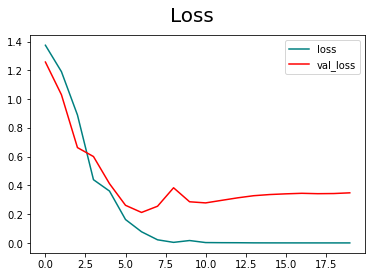

In [13]:
#hist.history
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'red', label = 'val_loss')

fig.suptitle("Loss", fontsize = 20)
plt.legend()
plt.show()

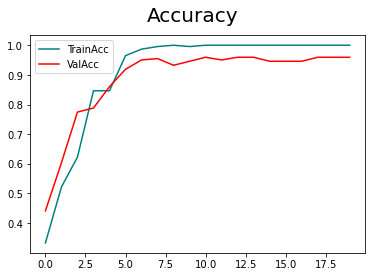

In [14]:
#hist.history
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'TrainAcc')
plt.plot(hist.history['val_accuracy'], color = 'red', label = 'ValAcc')

fig.suptitle("Accuracy", fontsize = 20)
plt.legend()
plt.show()

# Evaluation
Want to see how well this works on testing data

old code 
from tensorflow.keras.metrics import Precision, Recall ,  SparseCategoricalCrossentropy
#pre = Precision()
#re = Recall()
acc = SparseCategoricalCrossentropy()#SparseCategoricalCrossentropy() # might have to change this when we have more than 2 cats

In [15]:
loss, accuracy = model.evaluate([X_test, stats_test, hu_test], Y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9714 - loss: 0.1536


In [16]:
#print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')


print("Loss: " + str(loss))
print("Accuracy: "+ str(accuracy))

Loss: 0.1646009236574173
Accuracy: 0.9684684872627258


In [19]:
imageTest = cv2.imread('dataset/C/C)_1_1.jpg')
image_np = np.array(imageTest)
grayscale_image = cv2.cvtColor(imageTest, cv2.COLOR_RGB2GRAY)

prediction = model.predict(imageTest, calculate_stats(imageTest, 0), calculate_hu_moments(imageTest, 0))

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
